In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# выводим сразу два графика для сравнения
def plot_results(true, predicted):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].scatter(true['0'], true['1'], c=true['class'])
    ax[0].set_title("True classes")
    ax[1].scatter(predicted[:, 0], predicted[:, 1], c=cityblock_outliers)
    ax[1].set_title("Predicted clusters")
    plt.show()

In [3]:
'''
Из изначального датасета я возьму выборку включающую в себя 10000 случайно выбранных строк, промаркированных как Class 0 и возьму все строки имеющие маркировку Class 1
В этом ноутбуке будет происходить только поиск аномалий.
'''

'\nИз изначального датасета я возьму выборку включающую в себя 10000 случайно выбранных строк, промаркированных как Class 0 и возьму все строки имеющие маркировку Class 1\nВ этом ноутбуке будет происходить только поиск аномалий.\n'


# 「 Dataset Loading. No need 4 EDA 」

In [4]:
outlaw_full_prune = pd.read_csv('outlaw_full_prune.csv') # оригинальный, не скалированный дадтафрейм со всеми фмчами, но количество строк 10500, есть колонка Class

In [5]:
outlaw_full_prune_scale = pd.read_csv('df_outlaw_full_prune_no_Class_scale.csv') #скалированный дадтафрейм со всеми фмчами, но количество строк 10500, есть колонка Class

In [6]:
high_corr = ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V18', 'V1', 'V9'] # самые скорелированные фичи

In [7]:
df_outlaw_full_prune_scale_pca_2 =  pd.read_csv('df_outlaw_full_prune_no_Class_scale_pca_2.csv') #скалированный датафрейм с произведённым РСА в 2 колонки + колонка Class

In [8]:
outlaw_full_prune.shape

(10492, 31)

In [9]:
df_outlaw_full_prune_scale_pca_2.shape

(10492, 3)

#  Простейшие методы
## <center> 3-сигмы</center>

In [10]:
data_features = outlaw_full_prune.iloc[:, :-1]

In [11]:
'''
функция вычисляет среднее в колонке для каждого признака,
вычисляет верхнюю и нижнюю границы и подсвечивает объекты,
которые отклоняются больше чем на 3 сигмы от среднего
'''
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

#используя предыдушую функцию проходится по датасету
def get_column_outliers(data, columns=None, function=outlier_std, threshold=4.28):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)

    return comparison_table, outliers

def anomalies_report(outliers):
   print(f"Total number of outliers: {sum(outliers)}\nPercentage of outliers: {100*sum(outliers)/len(outliers)}")

In [12]:
comparison_table, sigma_outliers = get_column_outliers(data_features)
anomalies_report(sigma_outliers)

Total number of outliers: 494
Percentage of outliers: 4.708349218452154


In [13]:
comparison_table

upper_bound    lower_bound  anomalies_count  anomalies_percentage
V17          9.077400      -9.675071            160.0              1.524971
V14          8.032017      -8.659609            156.0              1.486847
V12          7.851399      -8.455207            140.0              1.334350
V16          6.134852      -6.515092            129.0              1.229508
V10          7.785725      -8.300283            125.0              1.191384
V7          10.658730     -11.126926            105.0              1.000762
V3          10.841567     -11.516212             98.0              0.934045
V1          10.847539     -11.293053             96.0              0.914983
V2           8.530127      -8.246003             93.0              0.886390
V11          6.098148      -5.768583             91.0              0.867327
V18          4.759862      -4.935636             90.0              0.857796
V8           8.185169      -8.158933             90.0              0.857796
V5           9.101639      -9.406116             89.0              0.848265
V23          2.805829      -2.820541             75.0              0.714830
V27          2.512140      -2.498965             72.0              0.686237
V21          4.967045      -4.897904             70.0              0.667175
V4           7.834577      -7.422453             68.0              0.648113
V9           5.462499      -5.723467             60.0              0.571864
V28          1.651588      -1.645833             60.0              0.571864
V20          4.061798      -4.052449             58.0              0.552802
Amount    1601.637047   -1409.955653             57.0              0.543271
V22          3.372658      -3.357234             30.0              0.285932
V25          2.292930      -2.279469             22.0              0.209684
V19          3.741702      -3.671774             18.0              0.171559
V26          2.073185      -2.069742             13.0              0.123904
V6           6.584483      -6.688174             11.0              0.104842
V24          2.578133      -2.594792              5.0              0.047655
V15          3.906670      -3.919526              2.0              0.019062
V13          4.339160      -4.316115              1.0              0.009531
Time    298264.837458 -110258.605090              0.0              0.000000

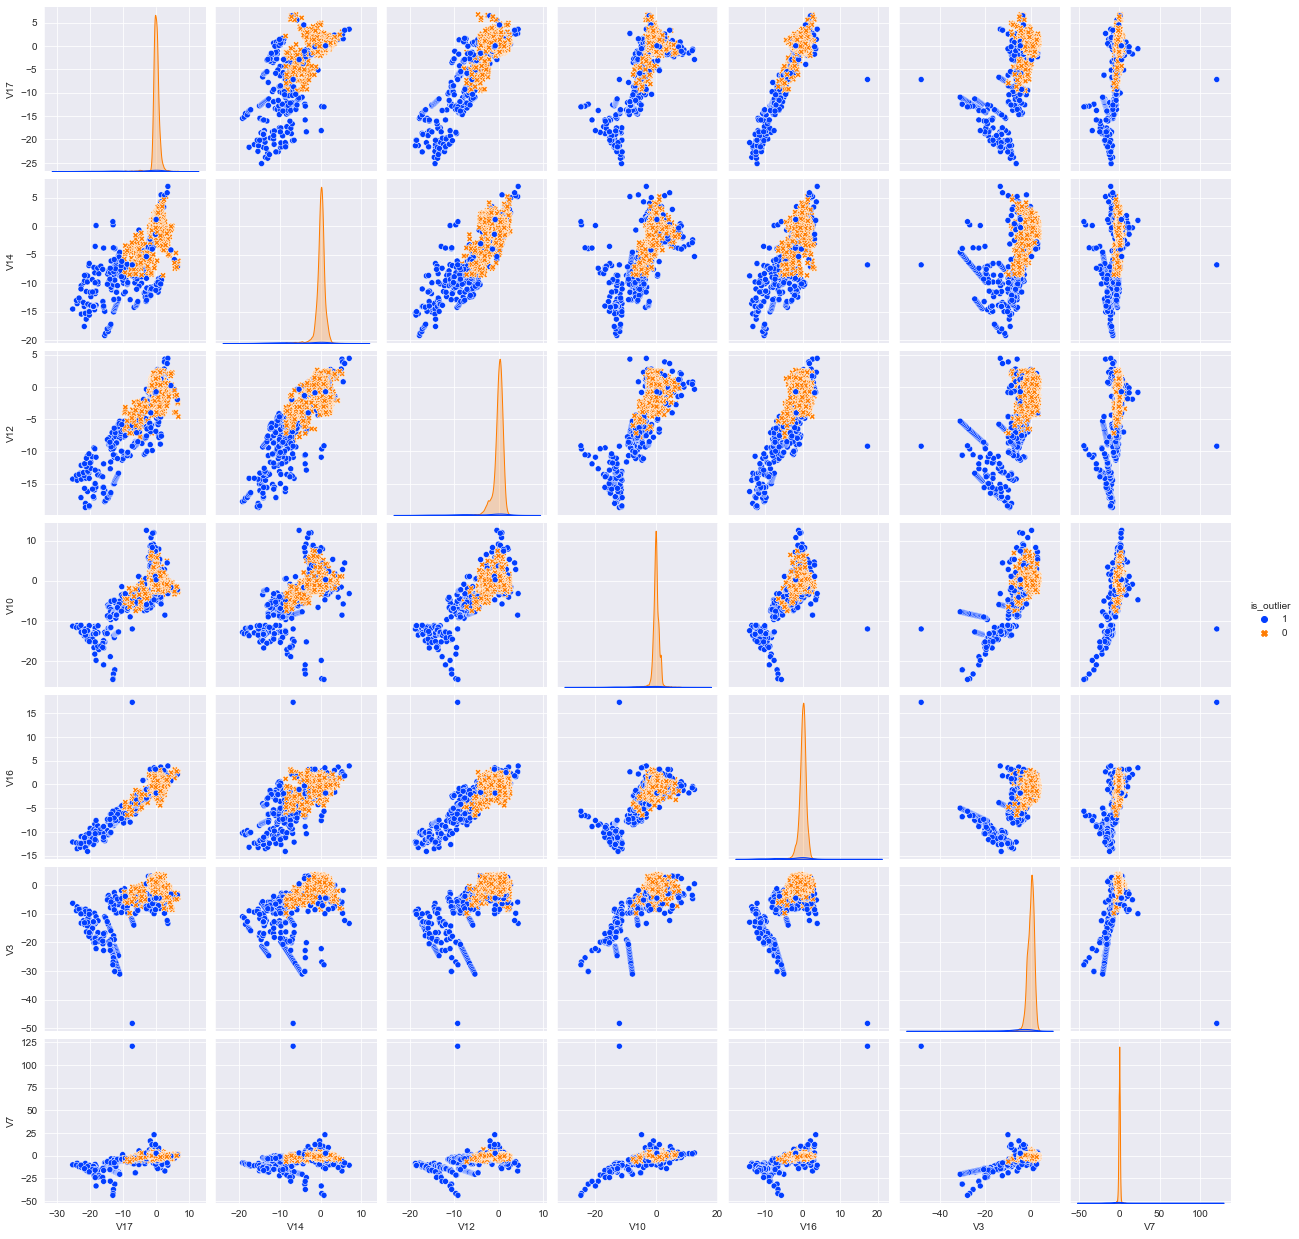

In [14]:
labeled_data = data_features[high_corr].copy()
labeled_data['is_outlier'] = sigma_outliers

sns.pairplot(data=labeled_data, vars = high_corr[:7],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright')

## <center> Межквартильное отклонение</center>
## <center> Box Plot (ящик с усами)</center>

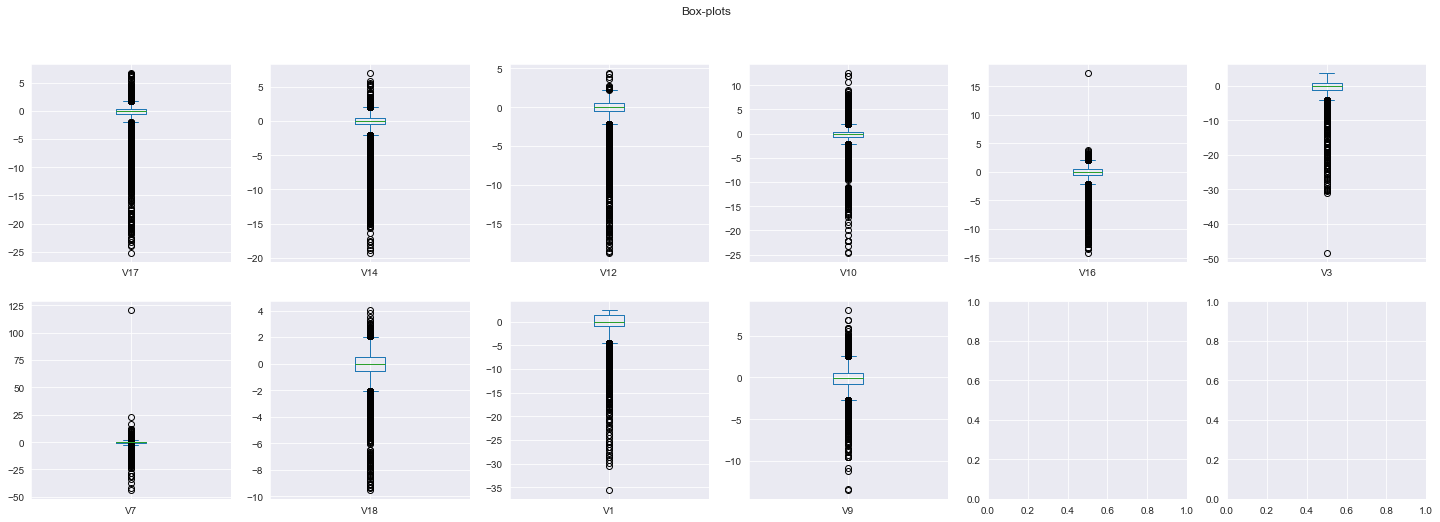

In [22]:
fig, axes = plt.subplots(2, 6, figsize=(25, 8))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data_features[high_corr]):
    data_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

In [23]:
# считаем квантили
def outlier_iqr(data, col, threshold=0):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [24]:
comparison_table, quant_outliers = get_column_outliers(data_features, function=outlier_iqr)
anomalies_report(quant_outliers)#(iqr_outliers)
# при любом значении параметра threshold количество аномалий не меняется

Total number of outliers: 1485
Percentage of outliers: 14.153640869233701


In [25]:
comparison_table

upper_bound    lower_bound  anomalies_count  anomalies_percentage
Amount     405.514400    -319.659400            498.0              4.746474
V27          0.869572      -0.835271            492.0              4.689287
V28          0.667072      -0.635009            370.0              3.526496
V8           2.805802      -2.666719            347.0              3.307282
V14          4.787427      -4.839944            344.0              3.278689
V20          1.690468      -1.750722            342.0              3.259626
V17          4.429390      -4.553953            303.0              2.887915
V12          5.328632      -5.270022            262.0              2.497141
V10          4.899842      -5.073125            256.0              2.439954
V21          2.065159      -2.080788            223.0              2.125429
V23          1.494836      -1.522825            214.0              2.039649
V7           5.527429      -5.572371            207.0              1.972932
V16          5.034701      -5.068026            183.0              1.744186
V2           7.051908      -6.755284            152.0              1.448723
V5           6.425954      -6.565004            128.0              1.219977
V3           9.791276      -9.903311            112.0              1.067480
V1          11.219081     -10.936596             98.0              0.934045
V18          4.903303      -4.934168             90.0              0.857796
V4           8.158148      -8.078027             62.0              0.590926
V11          7.412442      -7.315124             44.0              0.419367
V6           5.428088      -5.847771             44.0              0.419367
V9           6.123517      -6.298657             43.0              0.409836
V22          5.212025      -5.209388             15.0              0.142966
V26          2.681818      -2.761843              6.0              0.057186
V25          3.233924      -3.182580              5.0              0.047655
V19          4.483868      -4.434250              3.0              0.028593
V15          5.811584      -5.763368              1.0              0.009531
V24          3.851063      -3.787594              1.0              0.009531
V13          6.394571      -6.356146              1.0              0.009531
Time    506482.400000 -314171.900000              0.0              0.000000

# <center>「 3. Кластеризация 」 </center>

## <center> Distance-based methods</center>

In [26]:

class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:

    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)

    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile

    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)

    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions


In [27]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features),
    columns=data_features.columns
    )

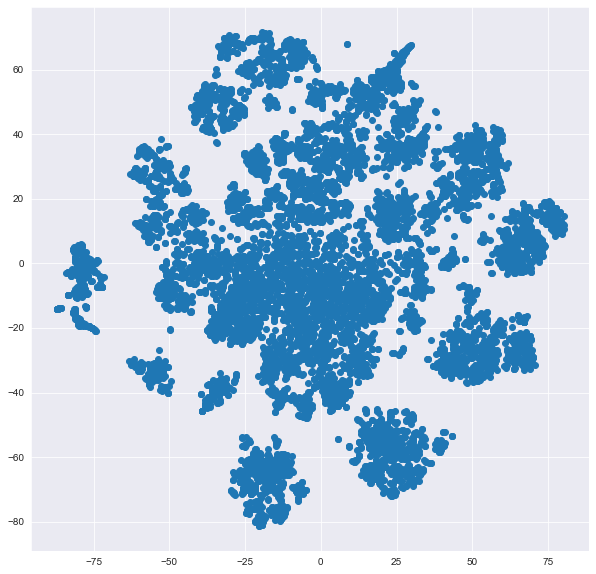

In [28]:
tsne = TSNE(perplexity=50, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1])

In [29]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=95.318)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers)

Total number of outliers: 492
Percentage of outliers: 4.689287075867328


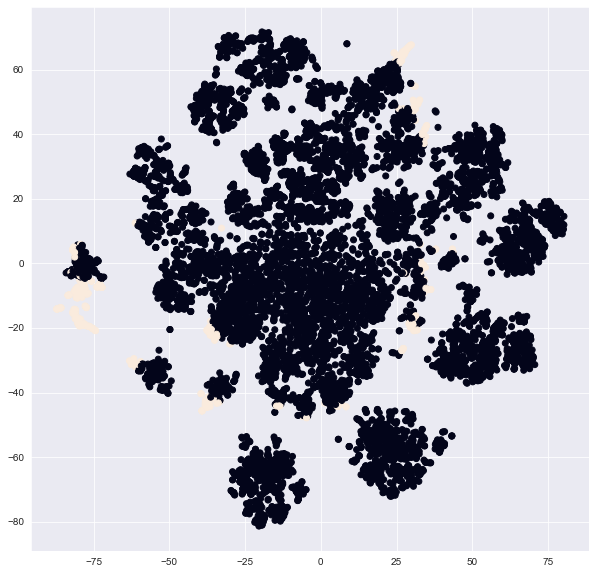

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers)

In [31]:
df_outlaw_full_prune_no_Class_scale_TSNE_2 = pd.read_csv('df_outlaw_full_prune_no_Class_scale_TSNE_2.csv') # dataset with True classes

NameError: name 'cityblock_outliers' is not defined

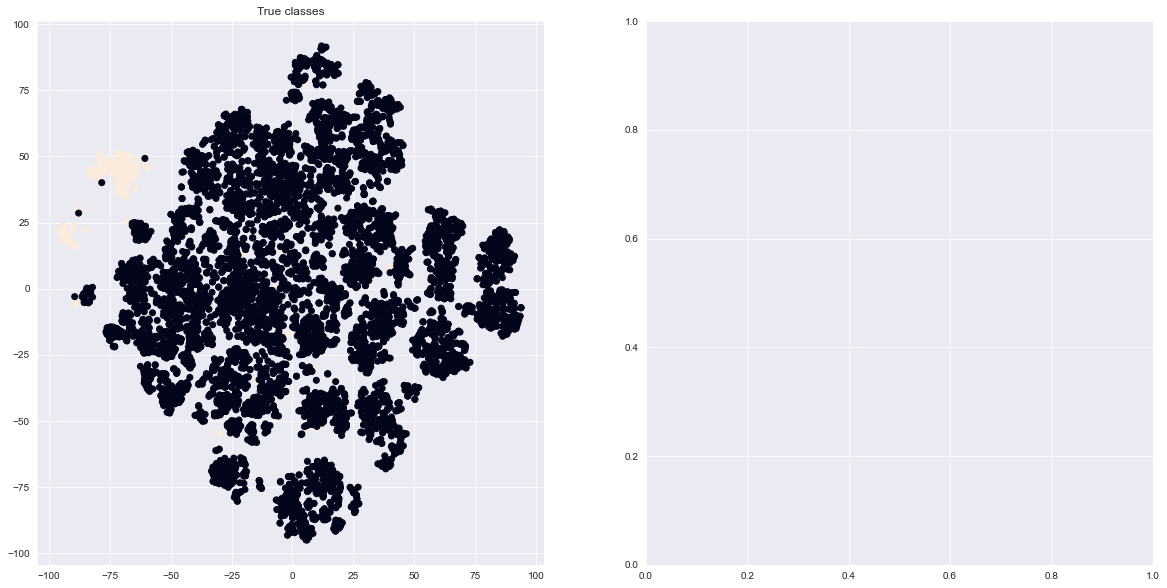

In [32]:
# Сравним на графике модель скалированную StandardScaler и классификацию модели скалированную RobustScaler с метрикой 'euclidean'
plot_results(df_outlaw_full_prune_no_Class_scale_TSNE_2, tsne_transformed)

In [33]:
# создадим модель с метрикой cityblock
citiblock_model = DistanceOutliers(metric='cityblock', percentile=95.315)
citiblock_model.fit(scaled_data)
cityblock_outliers = citiblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers)

labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

Total number of outliers: 492
Percentage of outliers: 4.689287075867328


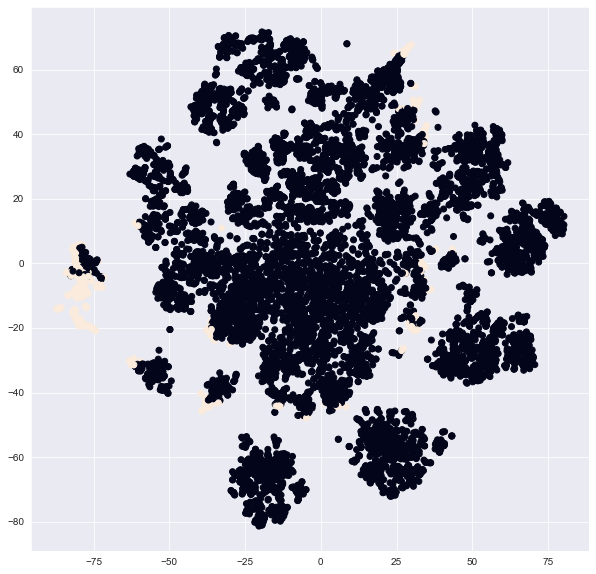

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers)

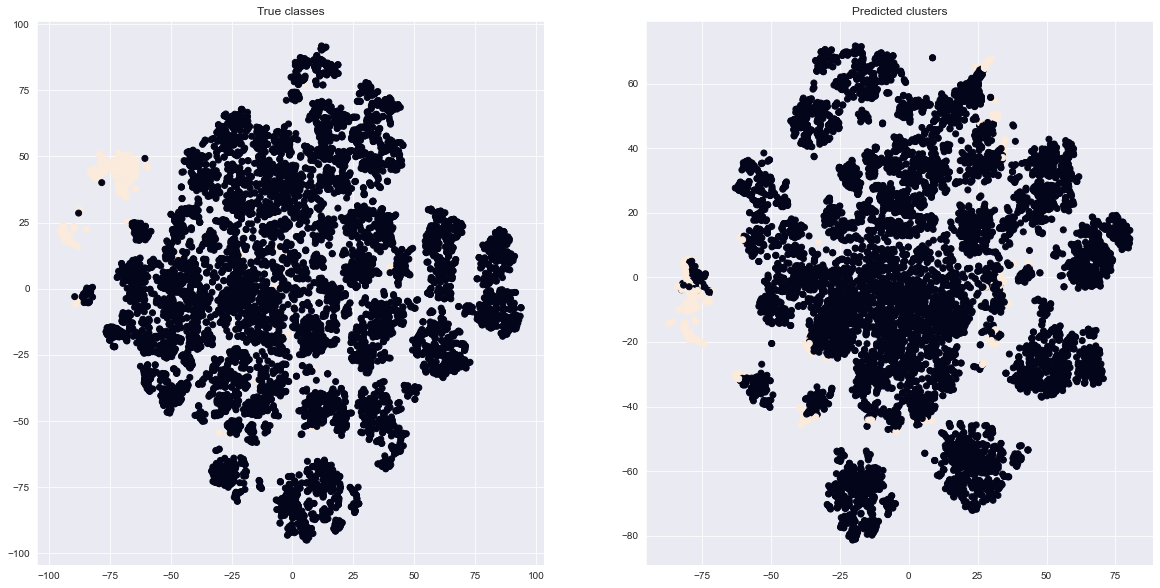

In [35]:
# Сравним на графике модель скалированную StandardScaler и классификацию модели скалированную RobustScaler с метрикой 'cityblock'
plot_results(df_outlaw_full_prune_no_Class_scale_TSNE_2, tsne_transformed)

In [36]:
df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned = pd.read_csv('df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned.csv')

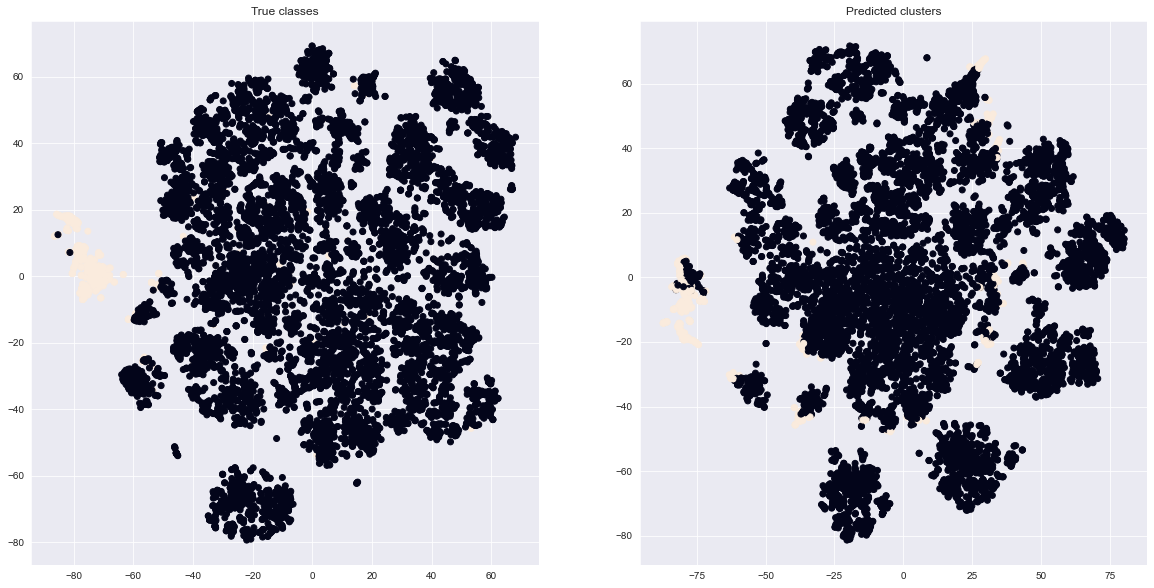

In [37]:
# Сравним на графике модель скалированную StandardScaler и TSNE оптимизированную методом силуэта, и классификацию модели скалированную RobustScaler с метрикой 'cityblock'
plot_results(df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned, tsne_transformed)

# <center>「 Density-based methods 」 </center>

## <center>DBSCAN</center>

In [38]:
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать, принимая количество аномалий за 5%
eps = 0.025
eps_history = [eps]
while outlier_percentage>0.05: # тут мы предполагаем процент аномалий (это одно из слабых мест этого алгоритма)
    model = DBSCAN(eps=eps).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)
    eps += 0.025
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

model = DBSCAN(eps)
model.fit(scaled_data)
dbscan_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [39]:
eps

6.025000000000018

In [40]:
anomalies_report(dbscan_outlier)

Total number of outliers: 522
Percentage of outliers: 4.975219214639726


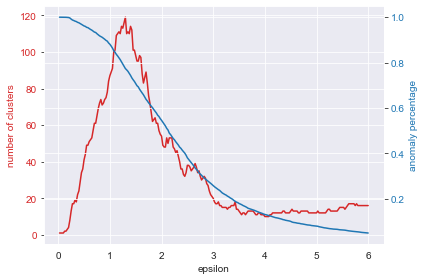

In [42]:
# посмотрим, как меняется процент аномалий и число кластеров с ростом эпсилон:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

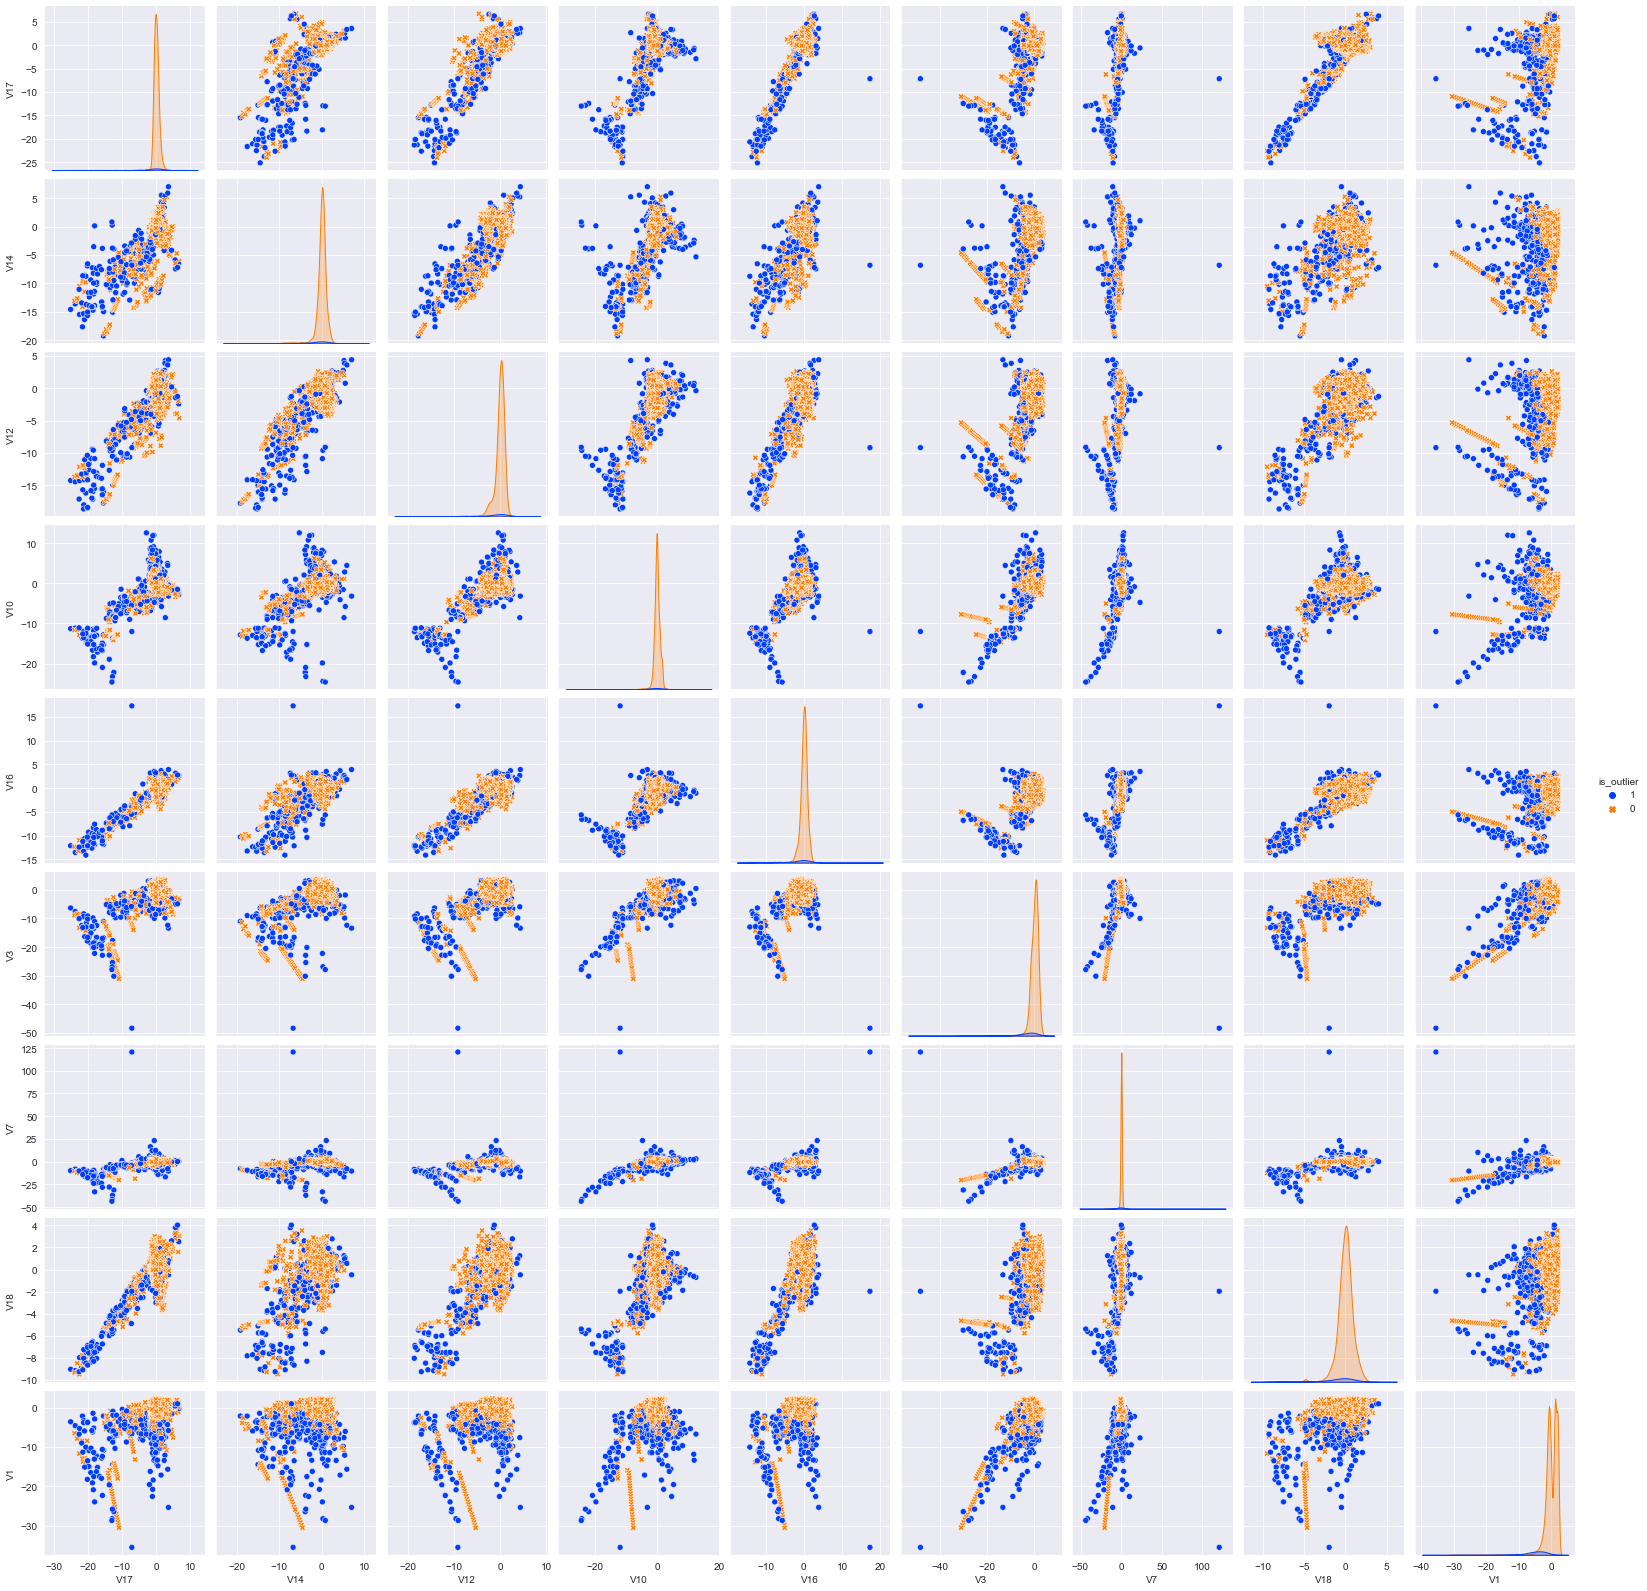

In [43]:
#визуализируем аномалии в разрезе высоко кореллированных признаков
labeled_data = data_features.copy()
labeled_data['is_outlier'] = dbscan_outlier

sns.pairplot(data=labeled_data, vars = high_corr[:9],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright')

In [44]:
'надо посмотреть на 3D график'

'надо посмотреть на 3D график'

'''
Precision measures the proportion of true positive predictions made by the model out of all positive predictions. It is calculated as the number of true positive predictions divided by the sum of true positive and false positive predictions. A high precision value indicates that the model is good at identifying true anomalies and not returning false positives.

Recall measures the proportion of true positive predictions made by the model out of all actual positive observations. It is calculated as the number of true positive predictions divided by the sum of true positive and false negative predictions. A high recall value indicates that the model is good at identifying all anomalies in the data.

F1 score is the harmonic mean of precision and recall. It is calculated as the harmonic mean of precision and recall, where the best value is 1 and the worst value is 0. The F1 score is a balance between precision and recall, taking into account both false positives and false negatives.
'''

# <center>「 Unsupervised model-based 」</center>

## <center>One-Class SVM</center>

In [46]:
'посмотрим, что нам покажет метод one_class_svm'
one_class_svm = OneClassSVM(nu=0.041, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [47]:
'при nu=0.05 метод нашёл почти на 100 объектов больше, что пятая часть настоящих аномалий. nu=0.41 - в самый раз'
anomalies_report(svm_outliers)

Total number of outliers: 498
Percentage of outliers: 4.746473503621807


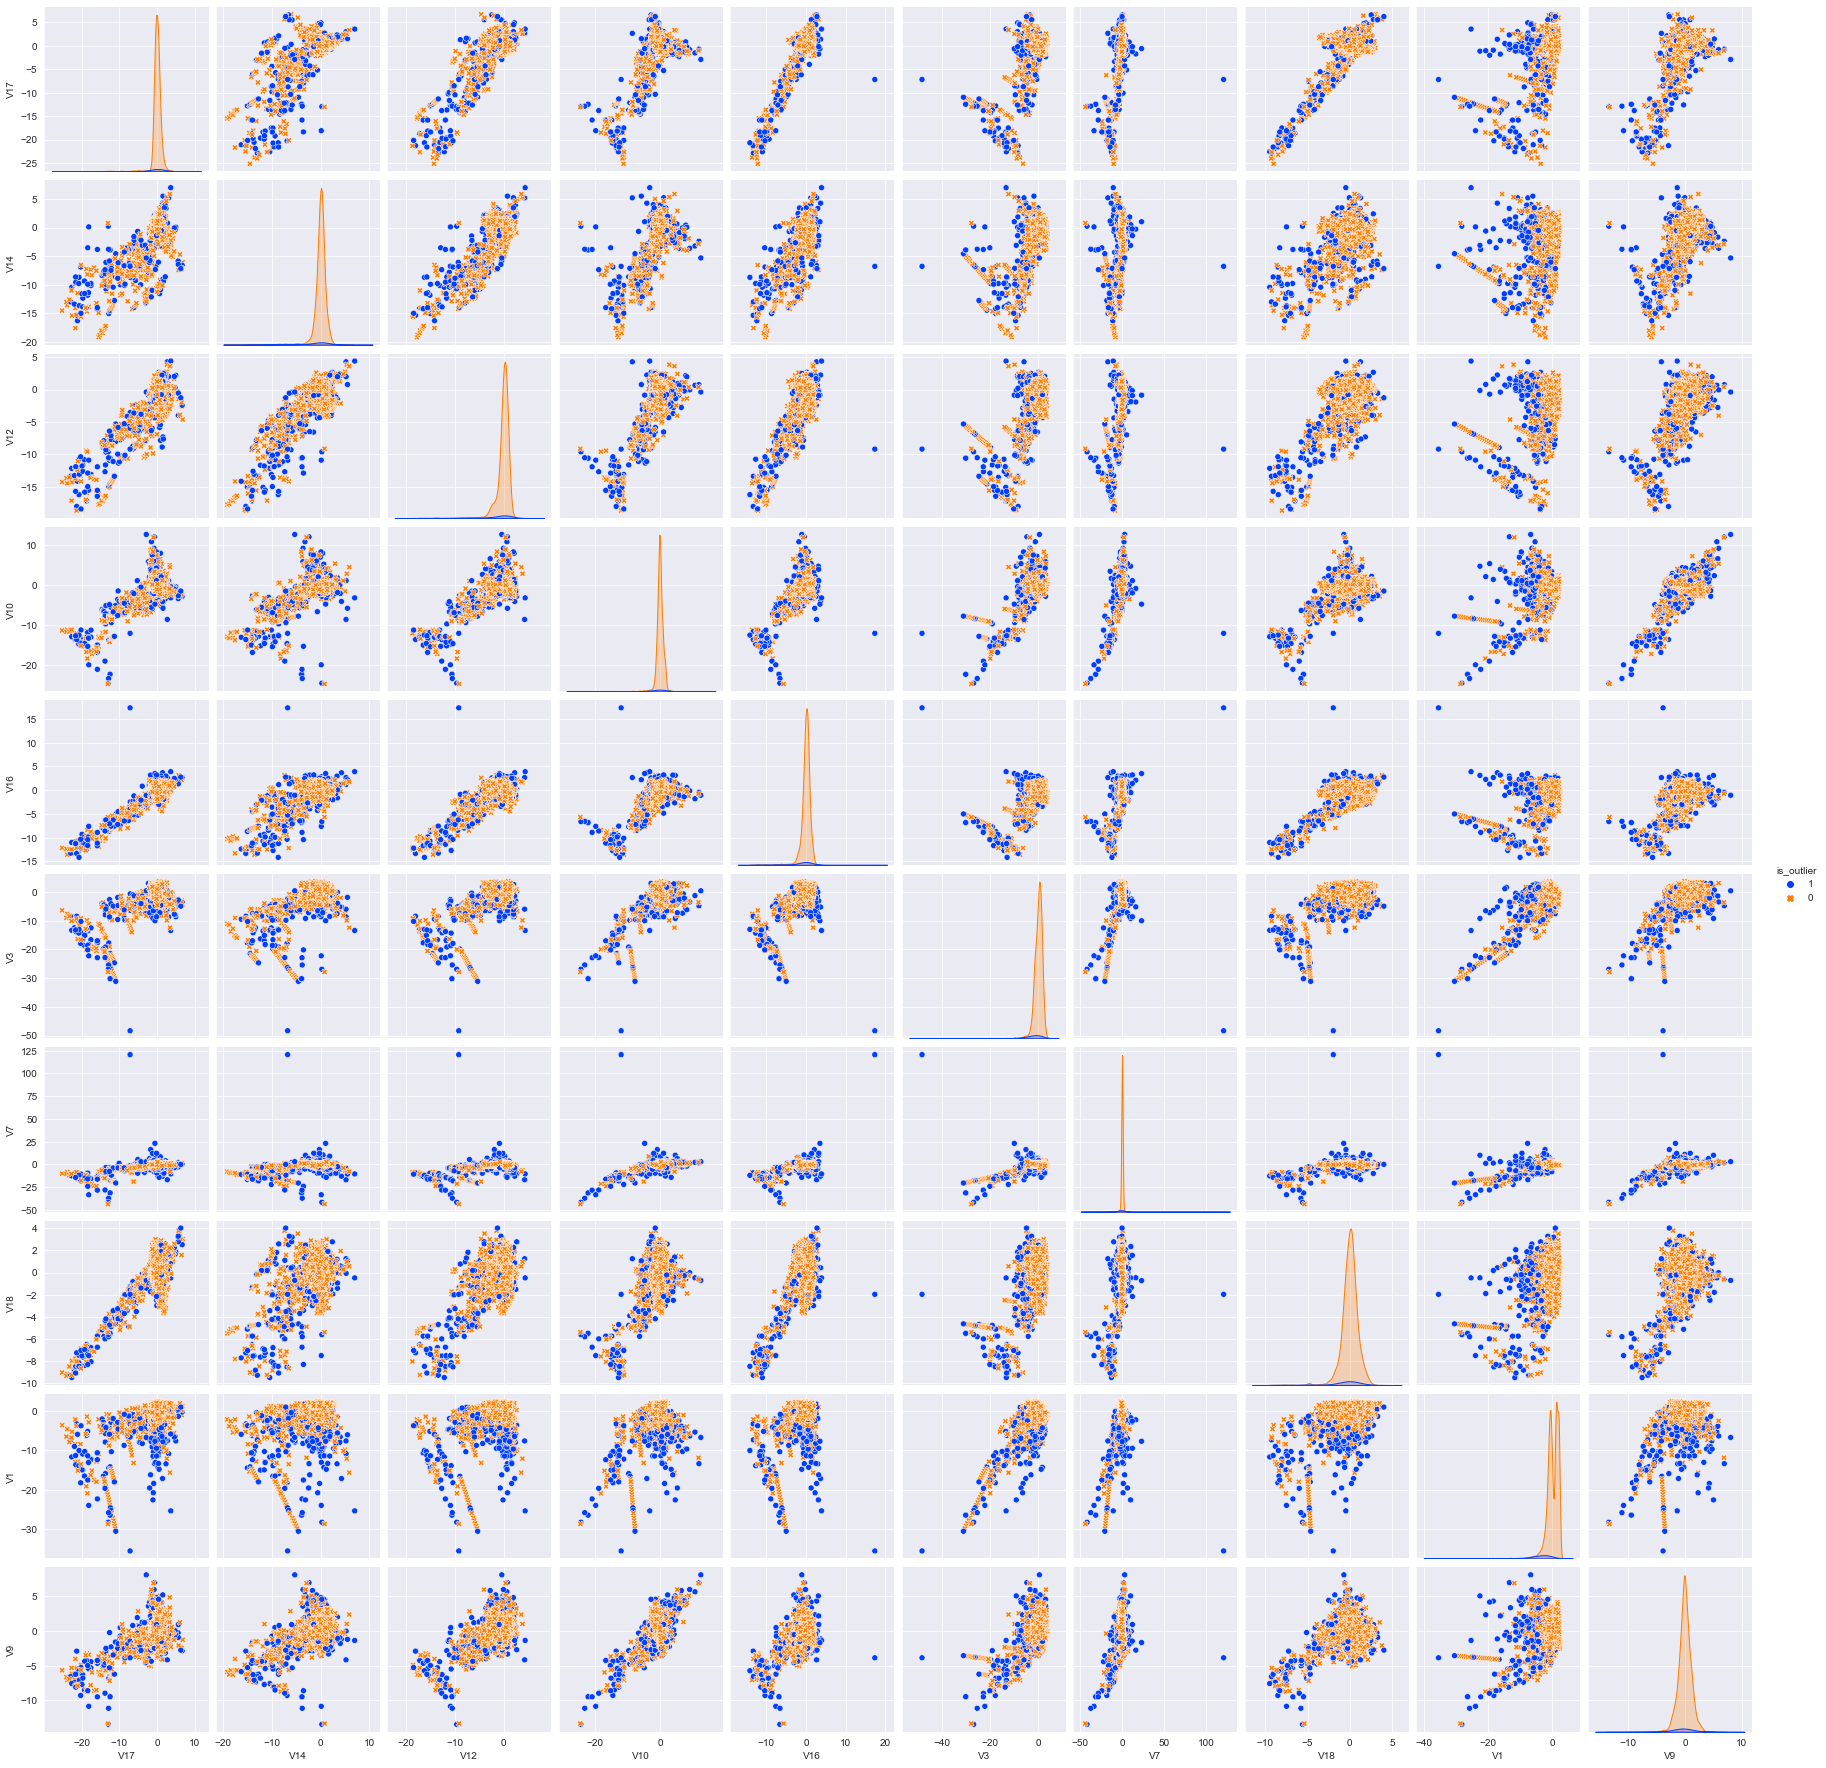

In [48]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = svm_outliers

sns.pairplot(data=labeled_data, vars = high_corr[:],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright')

In [ ]:
'''
True positive (TP) указывает на количество данных, корректно идентифицированных моделью как аномалии.
False positive (FP) указывает на количество данных, не корректно идентифицированных моделью как аномалии (нормальные данные были промаркированы как аномалии).
True negative (TN) указывает на количество данных, корректно идентифицированных моделью как нормальные данные.
False negative (FN) указывает на количество данных, не корректно идентифицированных моделью как нормальные (это аномальные данные, которые были идентифицированы как нормальные).
Для поиска максимального числа аномалий в данных нужно ориентироваться на метрики recall или F1 score.
Для уменьшения числа данных идентифицированных как False positive (FP) нужно отдать предпочтение метрике precision.
'''

## <center> 「 Метод Isolation Forest 」 </center>

In [49]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.047,
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [50]:
anomalies_report(isolation_outliers)

Total number of outliers: 494
Percentage of outliers: 4.708349218452154


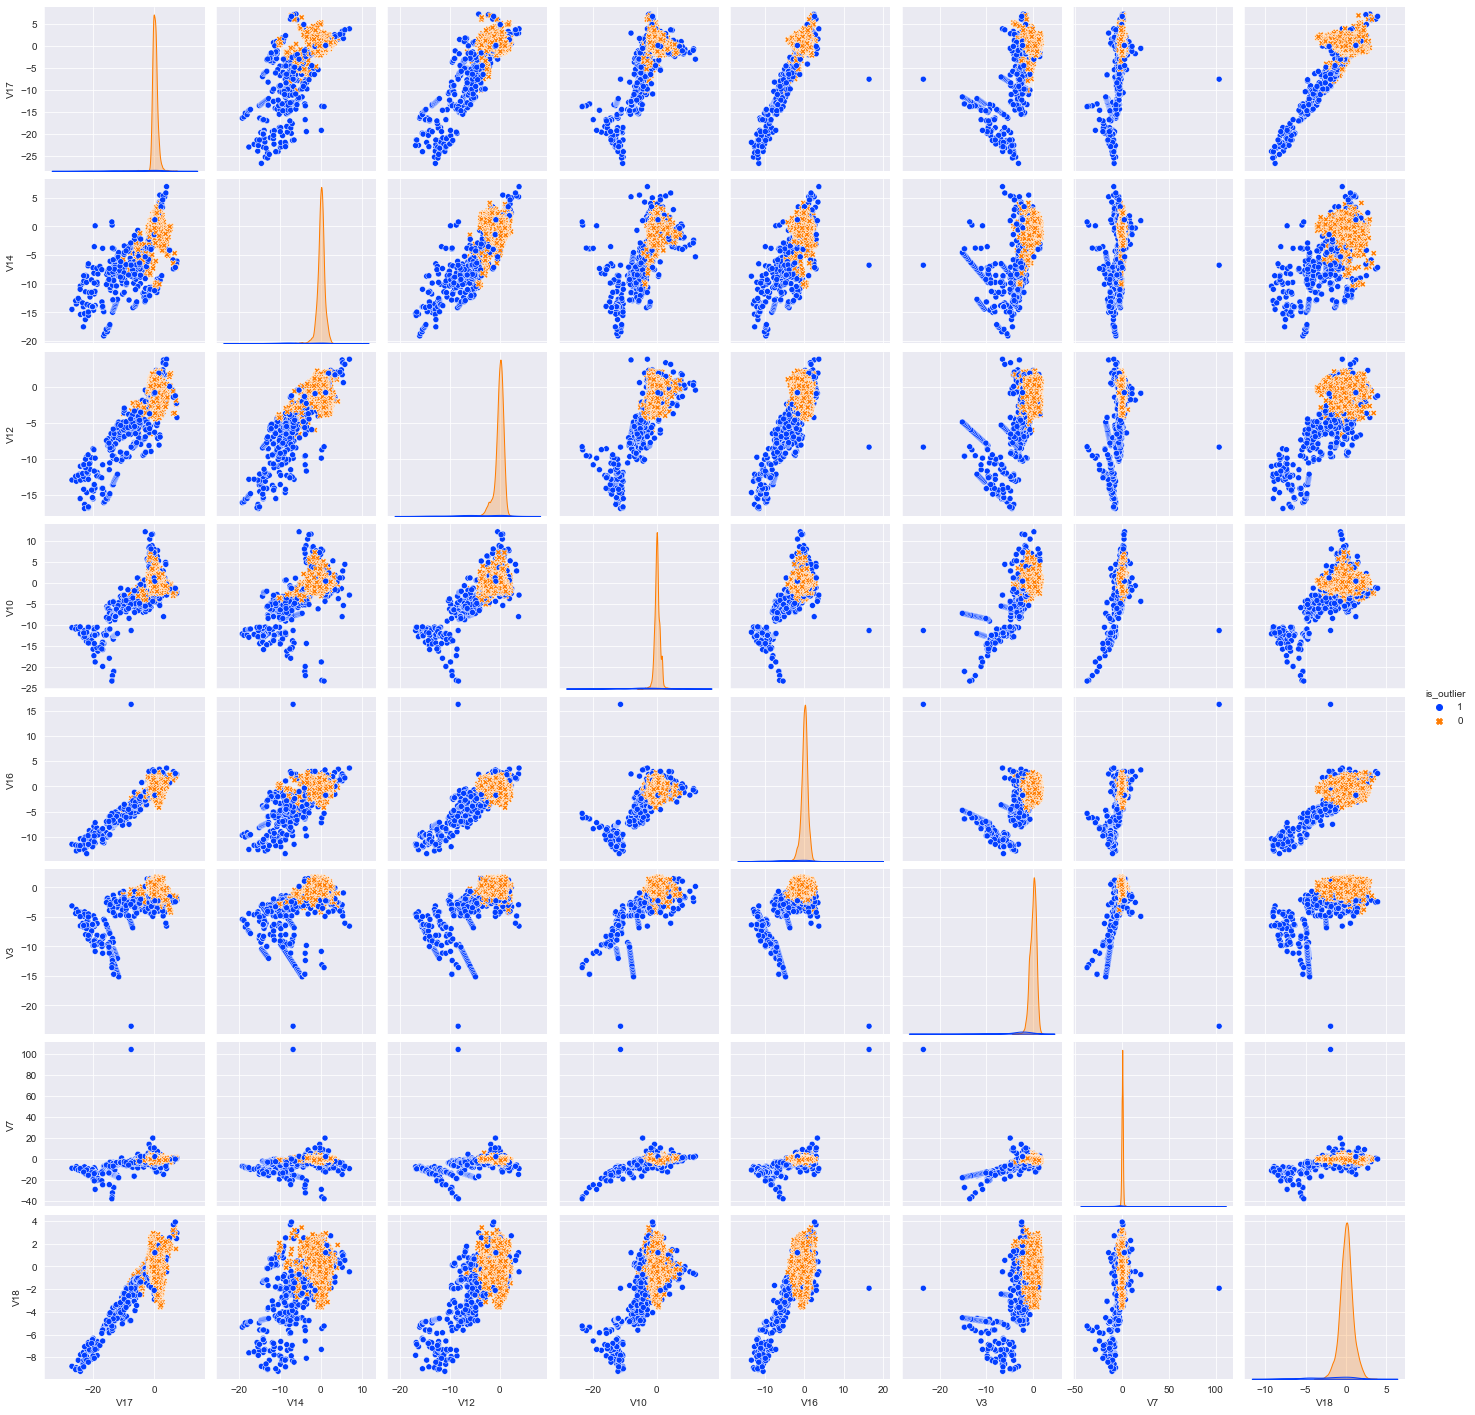

In [51]:
labeled_data = scaled_data.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = high_corr[:8],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright')

In [52]:
'''
Precision м Recall: Эти метрики отображают способность модели корректно отображать аномалии.
Высокий  precision score указывает на то, что модель хорошо идентифицирует настоящие аномалии,
    в то время как high recall score означает, что модель хороша в нахождении всех аномалий.
'''

'\nPrecision м Recall: Эти метрики отображают способность модели корректно отображать аномалии.\nВысокий  precision score указывает на то, что модель хорошо идентифицирует настоящие аномалии,\n    в то время как high recall score означает, что модель хороша в нахождении всех аномалий.\n'

# <center> 「 Финальное сравнение моделей и вывод матриц ошибок 」</center>

In [53]:
'''
[sigma_outliers, quant_outliers, euclidian_outliers, cityblock_outliers, dbscan_outlier, svm_outliers, isolation_outliers] - переменные с результатами методов
[3_sigma, quantile, euclidian_distance, cityblock_distance, DBSCAN, OneClassSVM, IsolationForest] - названия методов
'''

'\n[sigma_outliers, quant_outliers, euclidian_outliers, cityblock_outliers, dbscan_outlier, svm_outliers, isolation_outliers] - переменные с результатами методов\n[3_sigma, quantile, euclidian_distance, cityblock_distance, DBSCAN, OneClassSVM, IsolationForest] - названия методов\n'

In [54]:
np_summary = np.concatenate((
    [sigma_outliers],
    [quant_outliers],
    [euclidian_outliers],
    [cityblock_outliers],
    [dbscan_outlier],
    [svm_outliers],
    [isolation_outliers],
    [outlaw_full_prune_scale['class']]
))

In [55]:
outliers_titles = ['method_3_sigma', 'quantile', 'euclidian_distance', 'cityblock_distance', 'DBSCAN', 'One_Class_SVM', 'Isolation_Forest', 'Real_data']

In [56]:
summary = pd.DataFrame(
    np_summary.T,
    columns=['method_3_sigma', 'quantile', 'euclidian_distance', 'cityblock_distance', 'DBSCAN', 'One_Class_SVM', 'Isolation_Forest', 'Real_data']
)
summary.head() # датасет с результатами работы моделей

method_3_sigma  quantile  euclidian_distance  cityblock_distance  DBSCAN  \
0               0         0                   0                   0       0   
1               0         1                   0                   0       0   
2               0         1                   0                   0       1   
3               1         1                   1                   1       0   
4               0         1                   0                   0       0   

   One_Class_SVM  Isolation_Forest  Real_data  
0              1                 0          1  
1              0                 0          1  
2              1                 0          1  
3              1                 1          1  
4              0                 1          1

In [57]:
summary.sum(axis=1).value_counts() # тут мы смотрим сколько данных каким колличеством методов были размеченны как аномалии или нормальные (строчка "0")

0    8878
1     685
2     251
7     180
6     167
3     130
4      73
8      66
5      62
dtype: int64

In [58]:
summary.shape

(10492, 8)

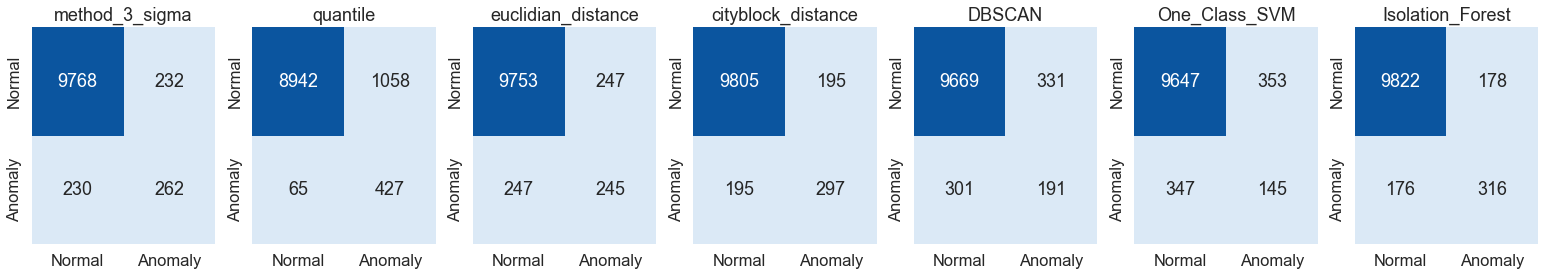

In [59]:
# Выведем для наглядности сразу все матрицы ошибок для ранее построенных моделей
sns.set(font_scale=1.5)
fig, axes = plt.subplots(1, summary.shape[1]-1, figsize=(27, 4))

for i in range(summary.shape[1]-1):
    sns.heatmap(confusion_matrix(outlaw_full_prune_scale['class'], summary[outliers_titles[i]]), fmt='.0f',
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'],
                cmap=sns.color_palette("Blues"),
                ax=axes[i],
                cbar=False,
                annot=True)
    axes[i].set_title(outliers_titles[i])

plt.show()

In [60]:
'''
true positives (аномалии обнаружены корректно),
true negatives (нормальные данные обнаружены корректно ),
false positives (нормальные данные обнаружены корректно и ошибочно помечены как аномалии ),
false negatives (аномалии ошибочно помечены как нормальные данные)
'''

'\ntrue positives (аномалии обнаружены корректно),\ntrue negatives (нормальные данные обнаружены корректно ),\nfalse positives (нормальные данные обнаружены корректно и ошибочно помечены как аномалии ),\nfalse negatives (аномалии ошибочно помечены как нормальные данные)\n'

In [61]:
# Создадим датасет со скорами precision, recall and F1 для всех моделей
metrics_scores = [] # список с результатами подсчёта метрик
for i in range(summary.shape[1]-1):
    metrics_scores.append(
                  [precision_score(outlaw_full_prune_scale['class'], summary[outliers_titles[i]]),
                   recall_score(outlaw_full_prune_scale['class'], summary[outliers_titles[i]]),
                   f1_score(outlaw_full_prune_scale['class'], summary[outliers_titles[i]]),
                   roc_auc_score(outlaw_full_prune_scale['class'], summary[outliers_titles[i]])]
    )

df_metrics_scores = pd.DataFrame(
                         np.array(metrics_scores).round(3),
                         columns=['precision', 'recall', 'f1-score', 'auc-roc'],
                         index=outliers_titles[:-1]
    )

df_metrics_scores # созданый датасет

precision  recall  f1-score  auc-roc
method_3_sigma          0.530   0.533     0.531    0.755
quantile                0.288   0.868     0.432    0.881
euclidian_distance      0.498   0.498     0.498    0.737
cityblock_distance      0.604   0.604     0.604    0.792
DBSCAN                  0.366   0.388     0.377    0.678
One_Class_SVM           0.291   0.295     0.293    0.630
Isolation_Forest        0.640   0.642     0.641    0.812

In [62]:
"""
лучше всего показа себя модель Isolation_Forest, за ней метод Межквартильного отклонения, но последний я выделил только потому, что этот метод неплохо опредилил аномалии,
 в остальном он оказался не очень хорош - у него много ошибок. все остальные методы и модели показали себя плохо, разочаровал DBSCAN
"""

'\nлучше всего показа себя модель Isolation_Forest, за ней метод Межквартильного отклонения, но последний я выделил только потому, что этот метод неплохо опредилил аномалии,\n в остальном он оказался не очень хорош - у него много ошибок. все остальные методы и модели показали себя плохо, разочаровал DBSCAN\n'

In [63]:
# df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned = pd.read_csv('df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned.csv')

In [64]:
outliers_list = [[sigma_outliers],[quant_outliers],[euclidian_outliers],[cityblock_outliers],[dbscan_outlier],[svm_outliers],[isolation_outliers]] # список переменных с результатами моделей

In [65]:
outliers_info = dict(zip(outliers_titles, outliers_list)) # словарь. состоящий из названия метода\модели и их результатов

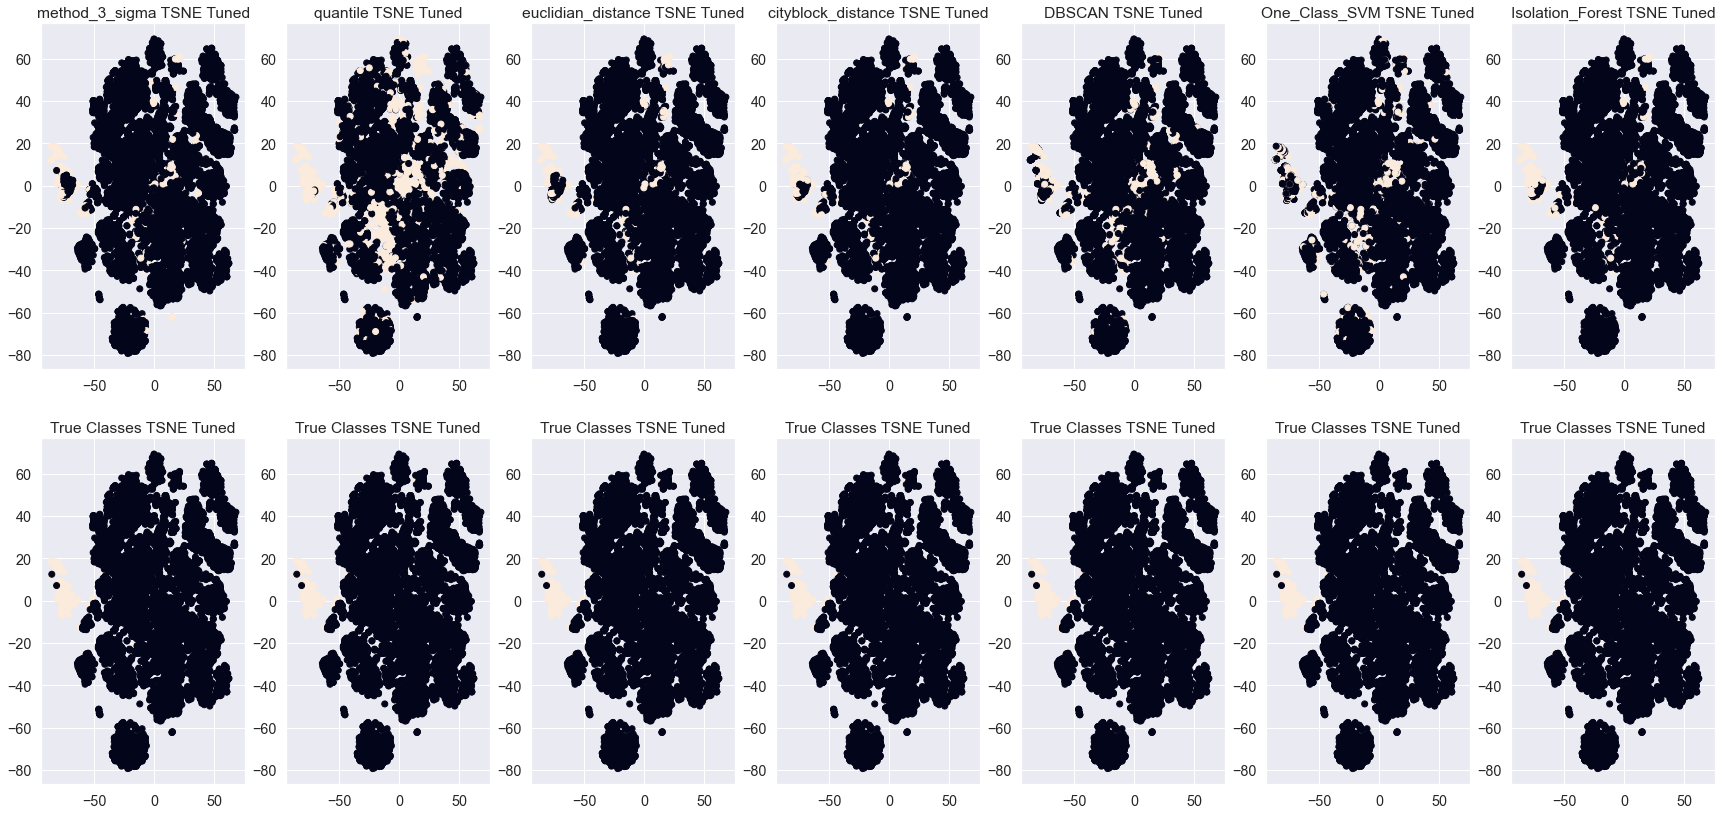

'\nна сводном графике можно наблюдать в верхнем ряду результат предсказания моделей, в нижнем - данные из первоначального датасета с истинной маркировкой.\nВывод всё тот же - Isolation_Forest отработал лучше всех, хотя так же надо отметить метод Межквартильного отклонения, который правильно пометил аномалии, но ложно пометил как аномалии много хороших данных.\n '

In [66]:
# Сравним на графике TSNE с perplexity со значением по умолчанию и TSNE оптимизированную методом силуэта
sns.set(font_scale=1.3)
def plot_results(true, predicted):
    fig, axes = plt.subplots(2, len(outliers_info), figsize=(30, 14))
    for num in enumerate(outliers_info):
        axes[0,num[0]].scatter(true.iloc[:, 0], true.iloc[:, 1], c=outliers_info[num[1]])
        axes[0,num[0]].set_title(f"{num[1]} TSNE Tuned")
        axes[1,num[0]].scatter(predicted.iloc[:, 0], predicted.iloc[:, 1], c=predicted['class'])
        axes[1,num[0]].set_title("True Classes TSNE Tuned")
    plt.show()

plot_results(df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned, df_outlaw_full_prune_no_Class_scale_TSNE_2_tuned)
"""
на сводном графике можно наблюдать в верхнем ряду результат предсказания моделей, в нижнем - данные из первоначального датасета с истинной маркировкой.
Вывод всё тот же - Isolation_Forest отработал лучше всех, хотя так же надо отметить метод Межквартильного отклонения, который правильно пометил аномалии, но ложно пометил как аномалии много хороших данных.
One Class SVM меня разочаровал, возможно, с этой моделью надо было поработать побольше.
 """

как заключение, хочу сказать, что мне понравилось прорабатывать задачу поиска аномалий и разбираться в методах обучения без учителя. так же я попробую ещё отдельно проработать улучшенную модель изолирующего леса.